# Atmospheric Precipitation, Temperature, and Cloudiness forecAST (APTCAST)

This notebook is the main notebook for the temperature aspect of the APTCAST project - forecasting atmospheric phenomena. Specific forecasted phenomena include precipitation, temperature and cloudiness. Each of these notebooks follow the same process:

1. Data Description
2. Libraries
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Non-ML Forecasting
6. ML Forecasting (stretch)

Due to compute limitations non-ML methods will the main focus of the forecasting. ML forecasting will be implemented after non-ML forecasting techniques are tested, as the non-ML forecasting can be used as a starting point for the ML predictions. 

## Data Description

The data for this project is the data retrieved from the National Oceanic and Atmospheric Administration's (NOAA) National Centers for Environmental Information (NCEI). NCEI has a tool, the climate data online (CDO), that allows for retrieving from an archive of global historical weather. In [CDO's geospatial data repository](https://www.ncei.noaa.gov/maps-and-geospatial-products), local climatological data can be ordered. For the scope of this project, Maui will be the focus of our forecasts. Only Kahului airport has a full non-null dataset between the dry bulb temperature, so Kahului airport's data will be used. Records go all the way back to 1996.

## Libraries

Libraries used in this notebook are shown in the imports below. Throughout this project, initial goal was to gain experience in forecasting as well as the polars library, so polars is used instead of pandas.

Statsmodels is another library I ended up employing that I have not used prior.

In [1]:
import numpy as np
import polars as pl
import itertools
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## EDA

In the EDA for this project, statistical methods will be used to find correlations within the data and find important relationships between fields, as well data cleaning.

### Loading Data

Data is loaded using polars and individual csvs retrieved from CDO are concatenated.

In [2]:
lf_1996 = pl.scan_csv("data/1996to2005.csv", ignore_errors=True).select("DATE", "DailyAverageDryBulbTemperature").drop_nulls()
lf_2015 = pl.scan_csv("data/2005to2015.csv", ignore_errors=True).select("DATE", "DailyAverageDryBulbTemperature").drop_nulls()
lf_2025 = pl.scan_csv("data/2015to2025.csv", ignore_errors=True).select("DATE", "DailyAverageDryBulbTemperature").drop_nulls()

In [3]:
lf_1996 = lf_1996.with_columns(
    pl.col("DailyAverageDryBulbTemperature").str.replace_all(r"[^0-9]", "").cast(pl.Int64).alias("TEMP")
)

lf_1996 = lf_1996.drop("DailyAverageDryBulbTemperature")

lf_2015 = lf_2015.rename({"DailyAverageDryBulbTemperature": "TEMP"})

lf_2025 = lf_2025.rename({"DailyAverageDryBulbTemperature": "TEMP"})

lf_full = pl.concat([lf_1996, lf_2015, lf_2025], how="vertical")

lf_full.collect()

DATE,TEMP
str,i64
"""1996-07-01T23:59:00""",83
"""1996-07-02T23:59:00""",83
"""1996-07-03T23:59:00""",82
"""1996-07-04T23:59:00""",79
"""1996-07-05T23:59:00""",80
…,…
"""2025-07-06T23:59:00""",81
"""2025-07-07T23:59:00""",80
"""2025-07-08T23:59:00""",80


### Outlier Removal

Visual inspection of data is used to find outliers within the data, and outliers are promptly removed due to model sensitivities to outliers.

In [4]:
lf_full.describe()

statistic,DATE,TEMP
str,str,f64
"""count""","""10332""",10332.0
"""null_count""","""0""",0.0
"""mean""",null,76.633082
"""std""",null,3.694641
"""min""","""1996-07-01T23:59:00""",50.0
"""25%""",null,74.0
"""50%""",null,77.0
"""75%""",null,79.0
"""max""","""2025-07-10T23:59:00""",86.0


In [5]:
intervals = lf_full.select("DATE").filter(pl.col("DATE").str.starts_with("1996-07-01") | pl.col("DATE").str.starts_with("2000-01-01") | pl.col("DATE").str.starts_with("2005-01-01") | pl.col("DATE").str.starts_with("2010-01-01") | pl.col("DATE").str.starts_with("2015-01-01") | pl.col("DATE").str.starts_with("2020-01-01") | pl.col("DATE").str.starts_with("2025-01-01")).collect().to_series()
intervals

DATE
str
"""1996-07-01T23:59:00"""
"""2000-01-01T23:59:00"""
"""2005-01-01T23:59:00"""
"""2010-01-01T23:59:00"""
"""2015-01-01T23:59:00"""
"""2020-01-01T23:59:00"""
"""2025-01-01T23:59:00"""


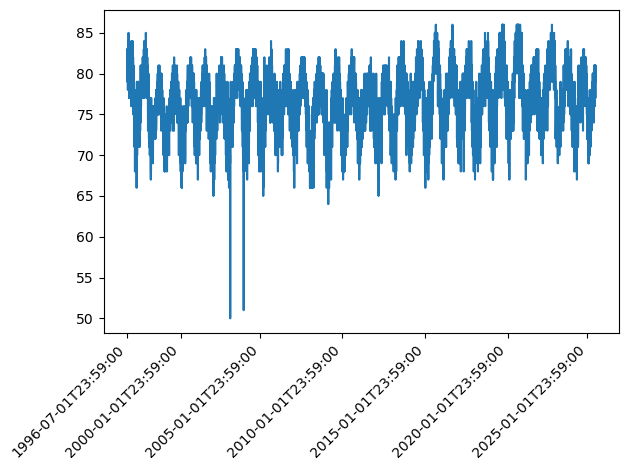

In [6]:
plt.plot(lf_full.select("DATE").collect().to_series(), lf_full.select("TEMP").collect().to_series())
plt.xticks(intervals, rotation=45, ha="right")
plt.tight_layout()

plt.show()

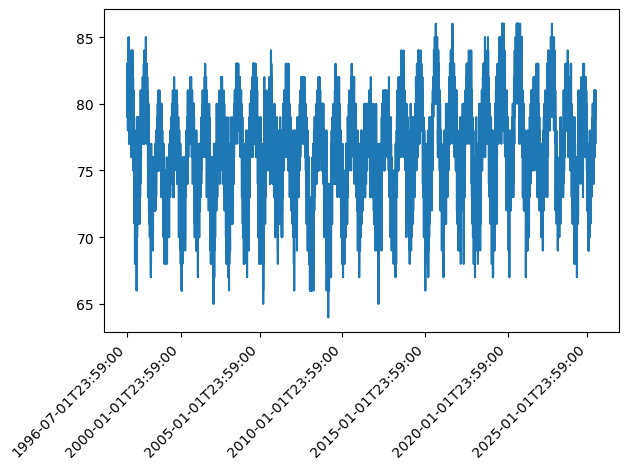

In [7]:
lf_full = lf_full.filter(pl.col("TEMP") > 55)
plt.plot(lf_full.select("DATE").collect().to_series(), lf_full.select("TEMP").collect().to_series())
plt.xticks(intervals, rotation=45, ha="right")
plt.tight_layout()

plt.show()

In [8]:
lf_full.describe()

statistic,DATE,TEMP
str,str,f64
"""count""","""10330""",10330.0
"""null_count""","""0""",0.0
"""mean""",null,76.638141
"""std""",null,3.677051
"""min""","""1996-07-01T23:59:00""",64.0
"""25%""",null,74.0
"""50%""",null,77.0
"""75%""",null,79.0
"""max""","""2025-07-10T23:59:00""",86.0


### Autocorrelation

The correlation of lags should be inspected for forecasting. Since there is seasonality in this data, both autocorrelation will be shown as well as partial autocorrelation to find both seasonality strength and optimal lags.

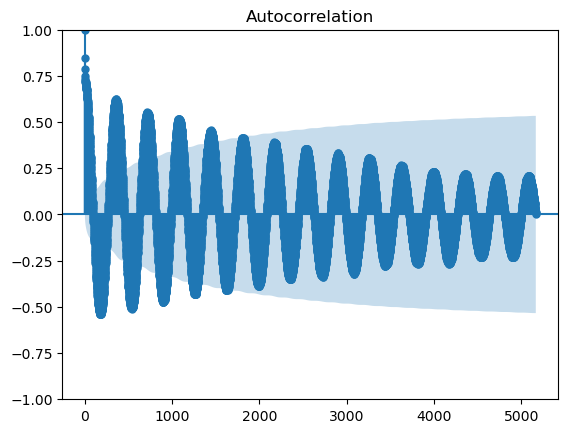

In [9]:
plot_acf(lf_full.select("TEMP").collect().to_series(), lags=len(lf_full.select("TEMP").collect().to_series()) // 2)
plt.show()

Seasonality is confirmed in the autocorrelation plot. It's also shown that there is some trend to the data, since correlation decreases after each period.

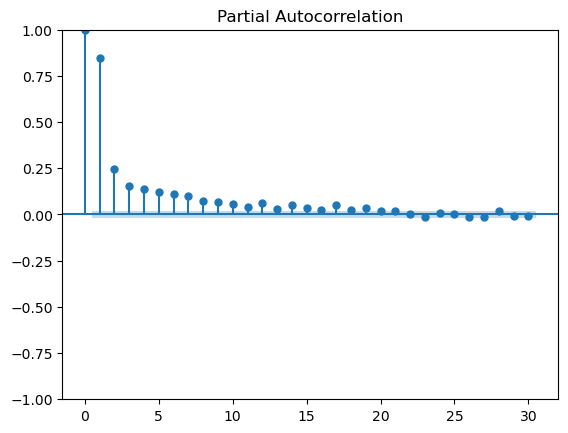

In [10]:
plot_pacf(lf_full.select("TEMP").collect().to_series(), lags=30)
plt.show()

Optimal lags up to 9 (0-9) will be tested in ARIMA model later, since autocorrelation is relatively low after that point.

## Feature Engineering

Easily ingestible fields can be engineered from the two current fields (DATE and TEMP)

### Date Fields

Time based fields can be extracted from the timestamps in the "DATE" column.

In [11]:
date_str = lf_full.select("DATE").collect().to_series().str.to_datetime("%Y-%m-%dT%H:%M:%S").dt

lf_full = lf_full.with_columns(
    date_str.year().alias("YEAR"),
    date_str.month().alias("MONTH"),
    date_str.day().alias("DAY"),
    date_str.hour().alias("HOUR"),
    date_str.minute().alias("MINUTE"),
    date_str.second().alias("SECOND")
    
)

lf_full.collect()

DATE,TEMP,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND
str,i64,i32,i8,i8,i8,i8,i8
"""1996-07-01T23:59:00""",83,1996,7,1,23,59,0
"""1996-07-02T23:59:00""",83,1996,7,2,23,59,0
"""1996-07-03T23:59:00""",82,1996,7,3,23,59,0
"""1996-07-04T23:59:00""",79,1996,7,4,23,59,0
"""1996-07-05T23:59:00""",80,1996,7,5,23,59,0
…,…,…,…,…,…,…,…
"""2025-07-06T23:59:00""",81,2025,7,6,23,59,0
"""2025-07-07T23:59:00""",80,2025,7,7,23,59,0
"""2025-07-08T23:59:00""",80,2025,7,8,23,59,0


In [12]:
lf_full = lf_full.select(["DATE", "YEAR", "MONTH", "DAY", "HOUR", "MINUTE", "SECOND", "TEMP"])
lf_full = lf_full.with_row_index()
lf_full.collect()

index,DATE,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,TEMP
u32,str,i32,i8,i8,i8,i8,i8,i64
0,"""1996-07-01T23:59:00""",1996,7,1,23,59,0,83
1,"""1996-07-02T23:59:00""",1996,7,2,23,59,0,83
2,"""1996-07-03T23:59:00""",1996,7,3,23,59,0,82
3,"""1996-07-04T23:59:00""",1996,7,4,23,59,0,79
4,"""1996-07-05T23:59:00""",1996,7,5,23,59,0,80
…,…,…,…,…,…,…,…,…
10325,"""2025-07-06T23:59:00""",2025,7,6,23,59,0,81
10326,"""2025-07-07T23:59:00""",2025,7,7,23,59,0,80
10327,"""2025-07-08T23:59:00""",2025,7,8,23,59,0,80


In [13]:
corr_schema = lf_full.drop("DATE").collect_schema()

for column in corr_schema.names():

    corr = lf_full.drop("DATE").select(pl.corr(column, "TEMP")).collect().item()
    print(f"{column}: {corr}") 

index: 0.14148376892383874
YEAR: 0.12538976446137035
MONTH: 0.42324397795515983
DAY: 0.015917693115134406
HOUR: nan
MINUTE: nan
SECOND: nan
TEMP: 1.0


Correlations for the date fields are shown - month having a higher correlation makes sense since temperature will change as the year goes on, but year by year they'll only change slightly. Hour, Minute, and Second are all nan since each record is at 23:59 each day.

### Seasons

As shown above, the month field has a relatively high correlation. This could also mean that seasons have a high correlation.

In [14]:
lf_full = lf_full.with_columns(
    pl.when((pl.col("MONTH") >= 3) & (pl.col("MONTH") <= 5)).then(3)
    .when((pl.col("MONTH") >= 6) & (pl.col("MONTH") <= 8)).then(2)
    .when((pl.col("MONTH") >= 9) & (pl.col("MONTH") <= 11)).then(1)
    .otherwise(0).alias("SEASON")
)
lf_full = lf_full.select(["index", "DATE", "YEAR", "SEASON", "MONTH", "DAY", "HOUR", "MINUTE", "SECOND", "TEMP"])

In [15]:
corr_schema = lf_full.drop("DATE").collect_schema()

for column in corr_schema.names():

    corr = lf_full.drop("DATE").select(pl.corr(column, "TEMP")).collect().item()
    print(f"{column}: {corr}") 

index: 0.14148376892383874
YEAR: 0.12538976446137035
SEASON: 0.21422565514481115
MONTH: 0.42324397795515983
DAY: 0.015917693115134406
HOUR: nan
MINUTE: nan
SECOND: nan
TEMP: 1.0


Relatively high correlation with normal seasons; however, since data is in Hawaii more granular field may be more useful. Specific solstice and equinox dates and times each year can be used to make it more granular.

In [16]:
soleq_lf = pl.scan_csv("data/solsticeequinox_hst.csv")
soleq_lf.collect()

YEAR,SPRING_DT,SUMMER_DT,AUTUMN_DT,WINTER_DT
i64,str,str,str,str
1996,"""1996-03-19T22:34:00""","""1996-06-20T16:23:00""","""1996-09-22T08:00:00""","""1996-12-21T04:06:00"""
1997,"""1997-03-20T03:54:00""","""1997-06-20T03:54:00""","""1997-09-22T13:55:00""","""1997-12-21T10:07:00"""
1998,"""1998-03-20T09:54:00""","""1998-06-21T04:02:00""","""1998-09-22T19:37:00""","""1998-12-21T15:56:00"""
1999,"""1999-03-20T15:46:00""","""1999-06-21T09:49:00""","""1999-09-23T01:31:00""","""1999-12-21T21:44:00"""
2000,"""2000-03-19T21:35:00""","""2000-06-20T15:47:00""","""2000-09-22T07:27:00""","""2000-12-21T03:37:00"""
…,…,…,…,…
2026,"""2026-03-20T04:45:00""","""2026-06-20T22:25:00""","""2026-09-22T14:05:00""","""2026-12-21T10:50:00"""
2027,"""2027-03-20T10:24:00""","""2027-06-21T04:10:00""","""2027-09-22T20:01:00""","""2027-12-21T16:42:00"""
2028,"""2028-03-19T16:17:00""","""2028-06-20T10:01:00""","""2028-09-22T01:45:00""","""2028-12-20T22:20:00"""


In [17]:
lf_full = lf_full.join(soleq_lf, on="YEAR", how='left')
lf_full.collect()

index,DATE,YEAR,SEASON,MONTH,DAY,HOUR,MINUTE,SECOND,TEMP,SPRING_DT,SUMMER_DT,AUTUMN_DT,WINTER_DT
u32,str,i32,i32,i8,i8,i8,i8,i8,i64,str,str,str,str
0,"""1996-07-01T23:59:00""",1996,2,7,1,23,59,0,83,"""1996-03-19T22:34:00""","""1996-06-20T16:23:00""","""1996-09-22T08:00:00""","""1996-12-21T04:06:00"""
1,"""1996-07-02T23:59:00""",1996,2,7,2,23,59,0,83,"""1996-03-19T22:34:00""","""1996-06-20T16:23:00""","""1996-09-22T08:00:00""","""1996-12-21T04:06:00"""
2,"""1996-07-03T23:59:00""",1996,2,7,3,23,59,0,82,"""1996-03-19T22:34:00""","""1996-06-20T16:23:00""","""1996-09-22T08:00:00""","""1996-12-21T04:06:00"""
3,"""1996-07-04T23:59:00""",1996,2,7,4,23,59,0,79,"""1996-03-19T22:34:00""","""1996-06-20T16:23:00""","""1996-09-22T08:00:00""","""1996-12-21T04:06:00"""
4,"""1996-07-05T23:59:00""",1996,2,7,5,23,59,0,80,"""1996-03-19T22:34:00""","""1996-06-20T16:23:00""","""1996-09-22T08:00:00""","""1996-12-21T04:06:00"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…
10325,"""2025-07-06T23:59:00""",2025,2,7,6,23,59,0,81,"""2025-03-19T23:01:00""","""2025-06-20T16:42:00""","""2025-09-22T08:19:00""","""2025-12-21T05:03:00"""
10326,"""2025-07-07T23:59:00""",2025,2,7,7,23,59,0,80,"""2025-03-19T23:01:00""","""2025-06-20T16:42:00""","""2025-09-22T08:19:00""","""2025-12-21T05:03:00"""
10327,"""2025-07-08T23:59:00""",2025,2,7,8,23,59,0,80,"""2025-03-19T23:01:00""","""2025-06-20T16:42:00""","""2025-09-22T08:19:00""","""2025-12-21T05:03:00"""


In [18]:
lf_full = lf_full.with_columns(

    pl.col("DATE").str.to_datetime("%Y-%m-%dT%H:%M:%S").alias("DATE"),
    pl.col("SPRING_DT").str.to_datetime("%Y-%m-%dT%H:%M:%S").alias("SPRING_DT"),
    pl.col("SUMMER_DT").str.to_datetime("%Y-%m-%dT%H:%M:%S").alias("SUMMER_DT"),
    pl.col("AUTUMN_DT").str.to_datetime("%Y-%m-%dT%H:%M:%S").alias("AUTUMN_DT"),
    pl.col("WINTER_DT").str.to_datetime("%Y-%m-%dT%H:%M:%S").alias("WINTER_DT")
    
)
lf_full.collect()

index,DATE,YEAR,SEASON,MONTH,DAY,HOUR,MINUTE,SECOND,TEMP,SPRING_DT,SUMMER_DT,AUTUMN_DT,WINTER_DT
u32,datetime[μs],i32,i32,i8,i8,i8,i8,i8,i64,datetime[μs],datetime[μs],datetime[μs],datetime[μs]
0,1996-07-01 23:59:00,1996,2,7,1,23,59,0,83,1996-03-19 22:34:00,1996-06-20 16:23:00,1996-09-22 08:00:00,1996-12-21 04:06:00
1,1996-07-02 23:59:00,1996,2,7,2,23,59,0,83,1996-03-19 22:34:00,1996-06-20 16:23:00,1996-09-22 08:00:00,1996-12-21 04:06:00
2,1996-07-03 23:59:00,1996,2,7,3,23,59,0,82,1996-03-19 22:34:00,1996-06-20 16:23:00,1996-09-22 08:00:00,1996-12-21 04:06:00
3,1996-07-04 23:59:00,1996,2,7,4,23,59,0,79,1996-03-19 22:34:00,1996-06-20 16:23:00,1996-09-22 08:00:00,1996-12-21 04:06:00
4,1996-07-05 23:59:00,1996,2,7,5,23,59,0,80,1996-03-19 22:34:00,1996-06-20 16:23:00,1996-09-22 08:00:00,1996-12-21 04:06:00
…,…,…,…,…,…,…,…,…,…,…,…,…,…
10325,2025-07-06 23:59:00,2025,2,7,6,23,59,0,81,2025-03-19 23:01:00,2025-06-20 16:42:00,2025-09-22 08:19:00,2025-12-21 05:03:00
10326,2025-07-07 23:59:00,2025,2,7,7,23,59,0,80,2025-03-19 23:01:00,2025-06-20 16:42:00,2025-09-22 08:19:00,2025-12-21 05:03:00
10327,2025-07-08 23:59:00,2025,2,7,8,23,59,0,80,2025-03-19 23:01:00,2025-06-20 16:42:00,2025-09-22 08:19:00,2025-12-21 05:03:00


In [19]:
lf_full = lf_full.with_columns(

    pl.when((pl.col("DATE") >= pl.col("SPRING_DT")) & (pl.col("DATE") <= pl.col("SUMMER_DT"))).then(3)
        .when((pl.col("DATE") >= pl.col("SUMMER_DT")) & (pl.col("DATE") <= pl.col("AUTUMN_DT"))).then(2)
        .when((pl.col("DATE") >= pl.col("AUTUMN_DT")) & (pl.col("DATE") <= pl.col("WINTER_DT"))).then(1)    
        .when((pl.col("DATE") >= pl.col("WINTER_DT")) | (pl.col("DATE") <= pl.col("SPRING_DT"))).then(0).alias("SOLSTICE_SEASON"),
)

In [20]:
lf_full = lf_full.select(["index", "YEAR", "SEASON", "SOLSTICE_SEASON", "MONTH", "DAY", "TEMP"])

In [21]:
corr_schema = lf_full.collect_schema()

for column in corr_schema.names():

    corr = lf_full.select(pl.corr(column, "TEMP")).collect().item()
    print(f"{column}: {corr}") 

index: 0.1414837689238311
YEAR: 0.12538976446137035
SEASON: 0.21422565514481115
SOLSTICE_SEASON: 0.39398672183435746
MONTH: 0.42324397795515983
DAY: 0.015917693115134406
TEMP: 1.0


### Encoding

Fields must be encoded to be ingested correctly in ML models. Seasonal fields are encoded with sinusoidal encoding, and other numerical fields are normalized. Temp is separated from all other variables to become the target.

In [22]:
min_year = 1996
max_year = 2028

lf_full = lf_full.with_columns(

    ((pl.col("YEAR") - min_year) / (max_year - min_year)).alias("YEAR"),
    pl.when(pl.col("SOLSTICE_SEASON") == 3).then(1).otherwise(0).alias("SPRING"),
    pl.when(pl.col("SOLSTICE_SEASON") == 2).then(1).otherwise(0).alias("SUMMER"),
    pl.when(pl.col("SOLSTICE_SEASON") == 1).then(1).otherwise(0).alias("AUTUMN"),
    pl.when(pl.col("SOLSTICE_SEASON") == 0).then(1).otherwise(0).alias("WINTER"),
    np.sin(2 * np.pi * ((pl.col("MONTH") - 1) / 11)).alias("MONTH_SIN"),
    np.cos(2 * np.pi * ((pl.col("MONTH") - 1) / 11)).alias("MONTH_COS"),
    np.sin(2 * np.pi * ((pl.col("DAY") - 1) / 30)).alias("DAY_SIN"),
    np.cos(2 * np.pi * ((pl.col("DAY") - 1) / 30)).alias("DAY_COS"), 
    pl.col("TEMP").shift(-1).alias("TEMP_t-1"),
    pl.col("TEMP").shift(-2).alias("TEMP_t-2"),
    pl.col("TEMP").shift(-3).alias("TEMP_t-3"),
    pl.col("TEMP").shift(-4).alias("TEMP_t-4"),
    pl.col("TEMP").shift(-5).alias("TEMP_t-5"),
    pl.col("TEMP").shift(-6).alias("TEMP_t-6"),
    pl.col("TEMP").shift(-7).alias("TEMP_t-7"),
    pl.col("TEMP").shift(-8).alias("TEMP_t-8"),
    
)

lf_full = lf_full.with_columns(

    ((pl.col("TEMP_t-1") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-1"),
    ((pl.col("TEMP_t-2") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-2"),
    ((pl.col("TEMP_t-3") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-3"),
    ((pl.col("TEMP_t-4") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-4"),
    ((pl.col("TEMP_t-5") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-5"),
    ((pl.col("TEMP_t-6") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-6"),
    ((pl.col("TEMP_t-7") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-7"),
    ((pl.col("TEMP_t-8") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-8"),

)

In [23]:
lf_full = lf_full.drop_nulls().filter(pl.col("YEAR") >= 0)
y = lf_full.select(["index", "TEMP"])
X = lf_full.sort("index").drop(["MONTH", "DAY", "TEMP"])
X.collect()

index,YEAR,SEASON,SOLSTICE_SEASON,SPRING,SUMMER,AUTUMN,WINTER,MONTH_SIN,MONTH_COS,DAY_SIN,DAY_COS,TEMP_t-1,TEMP_t-2,TEMP_t-3,TEMP_t-4,TEMP_t-5,TEMP_t-6,TEMP_t-7,TEMP_t-8
u32,f64,i32,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0.0,2,2,0,1,0,0,-0.281733,-0.959493,0.0,1.0,0.863636,0.818182,0.681818,0.727273,0.818182,0.772727,0.818182,0.772727
1,0.0,2,2,0,1,0,0,-0.281733,-0.959493,0.207912,0.978148,0.818182,0.681818,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636
2,0.0,2,2,0,1,0,0,-0.281733,-0.959493,0.406737,0.913545,0.681818,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182
3,0.0,2,2,0,1,0,0,-0.281733,-0.959493,0.587785,0.809017,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182
4,0.0,2,2,0,1,0,0,-0.281733,-0.959493,0.743145,0.669131,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
10317,0.90625,2,2,0,1,0,0,0.281733,-0.959493,-0.743145,0.669131,0.772727,0.727273,0.636364,0.636364,0.590909,0.681818,0.727273,0.772727
10318,0.90625,2,2,0,1,0,0,0.281733,-0.959493,-0.587785,0.809017,0.727273,0.636364,0.636364,0.590909,0.681818,0.727273,0.772727,0.727273
10319,0.90625,2,2,0,1,0,0,0.281733,-0.959493,-0.406737,0.913545,0.636364,0.636364,0.590909,0.681818,0.727273,0.772727,0.727273,0.727273


### Train/Test Split

Final year (2024-2025) is used as the test set, and everything before is the training set. Since 2025 is not finished yet, test set will not be the entire year.

In [24]:
final_index = X.select(pl.len()).collect().item()
final_year_start = final_index - 356
X_test = X.filter(pl.col("index") >= final_year_start)
X_test.collect()

index,YEAR,SEASON,SOLSTICE_SEASON,SPRING,SUMMER,AUTUMN,WINTER,MONTH_SIN,MONTH_COS,DAY_SIN,DAY_COS,TEMP_t-1,TEMP_t-2,TEMP_t-3,TEMP_t-4,TEMP_t-5,TEMP_t-6,TEMP_t-7,TEMP_t-8
u32,f64,i32,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
9966,0.875,2,3,1,0,0,0,0.281733,-0.959493,0.406737,0.913545,0.681818,0.590909,0.636364,0.590909,0.590909,0.636364,0.727273,0.727273
9967,0.875,2,3,1,0,0,0,0.281733,-0.959493,0.587785,0.809017,0.590909,0.636364,0.590909,0.590909,0.636364,0.727273,0.727273,0.681818
9968,0.875,2,3,1,0,0,0,0.281733,-0.959493,0.743145,0.669131,0.636364,0.590909,0.590909,0.636364,0.727273,0.727273,0.681818,0.681818
9969,0.875,2,3,1,0,0,0,0.281733,-0.959493,0.866025,0.5,0.590909,0.590909,0.636364,0.727273,0.727273,0.681818,0.681818,0.727273
9970,0.875,2,3,1,0,0,0,0.281733,-0.959493,0.951057,0.309017,0.590909,0.636364,0.727273,0.727273,0.681818,0.681818,0.727273,0.727273
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
10317,0.90625,2,2,0,1,0,0,0.281733,-0.959493,-0.743145,0.669131,0.772727,0.727273,0.636364,0.636364,0.590909,0.681818,0.727273,0.772727
10318,0.90625,2,2,0,1,0,0,0.281733,-0.959493,-0.587785,0.809017,0.727273,0.636364,0.636364,0.590909,0.681818,0.727273,0.772727,0.727273
10319,0.90625,2,2,0,1,0,0,0.281733,-0.959493,-0.406737,0.913545,0.636364,0.636364,0.590909,0.681818,0.727273,0.772727,0.727273,0.727273


In [25]:
y_test = y.filter(pl.col("index").is_in(X_test.select("index").collect().to_series().to_list()))
y_test.collect()

index,TEMP
u32,i64
9966,78
9967,79
9968,77
9969,78
9970,77
…,…
10317,79
10318,81
10319,80


In [26]:
X_train = X.filter(~pl.col("index").is_in(X_test.select("index").collect().to_series().to_list()))
X_train.collect()

index,YEAR,SEASON,SOLSTICE_SEASON,SPRING,SUMMER,AUTUMN,WINTER,MONTH_SIN,MONTH_COS,DAY_SIN,DAY_COS,TEMP_t-1,TEMP_t-2,TEMP_t-3,TEMP_t-4,TEMP_t-5,TEMP_t-6,TEMP_t-7,TEMP_t-8
u32,f64,i32,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0.0,2,2,0,1,0,0,-0.281733,-0.959493,0.0,1.0,0.863636,0.818182,0.681818,0.727273,0.818182,0.772727,0.818182,0.772727
1,0.0,2,2,0,1,0,0,-0.281733,-0.959493,0.207912,0.978148,0.818182,0.681818,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636
2,0.0,2,2,0,1,0,0,-0.281733,-0.959493,0.406737,0.913545,0.681818,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182
3,0.0,2,2,0,1,0,0,-0.281733,-0.959493,0.587785,0.809017,0.727273,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182
4,0.0,2,2,0,1,0,0,-0.281733,-0.959493,0.743145,0.669131,0.818182,0.772727,0.818182,0.772727,0.863636,0.818182,0.818182,0.772727
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
9961,0.875,3,3,1,0,0,0,0.75575,-0.654861,-0.406737,0.913545,0.590909,0.590909,0.590909,0.681818,0.636364,0.681818,0.590909,0.636364
9962,0.875,3,3,1,0,0,0,0.75575,-0.654861,-0.207912,0.978148,0.590909,0.590909,0.681818,0.636364,0.681818,0.590909,0.636364,0.590909
9963,0.875,3,3,1,0,0,0,0.75575,-0.654861,-2.4493e-16,1.0,0.590909,0.681818,0.636364,0.681818,0.590909,0.636364,0.590909,0.590909


In [27]:
y_train = y.filter(pl.col("index").is_in(X_train.select("index").collect().to_series().to_list()))
y_train.collect()

index,TEMP
u32,i64
0,83
1,83
2,82
3,79
4,80
…,…
9961,77
9962,77
9963,77


## Non-ML Forecasting

From the autocorrelations, there is seasonality and trend in the data. SARIMA was tested; however, large runtimes prevent it from being used here. Instead, we can use statsmodels STLForecast, which breaks the data into trend and seasonality, and models the trend using ARIMA.

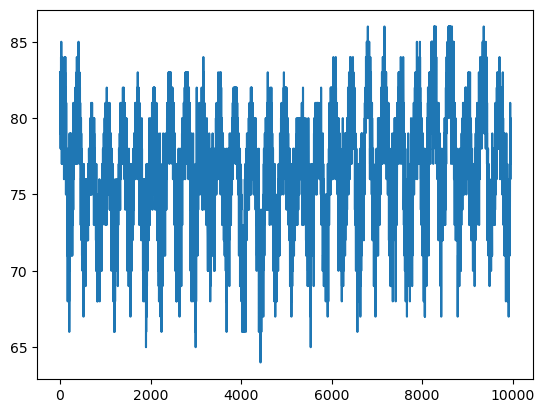

In [28]:
X_data = X_train.select("index").collect().to_series()
y_data = y_train.select("TEMP").collect().to_series()
plt.plot(X_data, y_data)

In [ ]:
p=d=q=range(0, 10)
pdq = list(itertools.product(p, d, q))
ARIMA = sm.tsa.arima.ARIMA
min_param = (0, 0, 0)
min_bic = float('inf')
sltf = sm.tsa.STLForecast(y_data, ARIMA, period=356)
for param in pdq:
    try:
        sltf = sm.tsa.STLForecast(y_data, ARIMA, model_kwargs=dict(order=param, trend='t'), period=356)
        sltf_fit = sltf.fit()
        bic = sltf_fit.model_result.bic
        min_param, min_bic = (param, bic) if bic < min_bic else (min_param, min_bic)
        print(f"{param}: {sltf_fit.model_result.bic}; Minimum bic - {min_param}: {min_bic} ")
    except ValueError as ve: 
        continue

(0, 0, 0): 100724.18869178976; Minimum bic - (0, 0, 0): 100724.18869178976 
(0, 0, 1): 87664.71732929004; Minimum bic - (0, 0, 1): 87664.71732929004 
(0, 0, 2): 77261.20591768; Minimum bic - (0, 0, 2): 77261.20591768 
(0, 0, 3): 69519.19357257344; Minimum bic - (0, 0, 3): 69519.19357257344 
(0, 0, 4): 64043.86965491475; Minimum bic - (0, 0, 4): 64043.86965491475 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


(0, 0, 5): 73254.97049454693; Minimum bic - (0, 0, 4): 64043.86965491475 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 0, 6): 56706.36328820562; Minimum bic - (0, 0, 6): 56706.36328820562 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 0, 7): 54335.17035985688; Minimum bic - (0, 0, 7): 54335.17035985688 
(0, 0, 8): 52311.50598386722; Minimum bic - (0, 0, 8): 52311.50598386722 
(0, 0, 9): 9.91186988159996e+18; Minimum bic - (0, 0, 8): 52311.50598386722 
(0, 1, 0): 37954.80729023112; Minimum bic - (0, 1, 0): 37954.80729023112 
(0, 1, 1): 36310.81710282249; Minimum bic - (0, 1, 1): 36310.81710282249 
(0, 1, 2): 35562.851956870734; Minimum bic - (0, 1, 2): 35562.851956870734 
(0, 1, 3): 35253.945609925504; Minimum bic - (0, 1, 3): 35253.945609925504 
(0, 1, 4): 35182.07773582816; Minimum bic - (0, 1, 4): 35182.07773582816 
(0, 1, 5): 35174.60230462944; Minimum bic - (0, 1, 5): 35174.60230462944 
(0, 1, 6): 35181.48596378362; Minimum bic - (0, 1, 5): 35174.60230462944 
(0, 1, 7): 35189.744176206594; Minimum bic - (0, 1, 5): 35174.60230462944 
(0, 1, 8): 35197.64462487618; Minimum bic - (0, 1, 5): 35174.60230462944 
(0, 1, 9): 35205.17448043257; Minimum bic - (0, 1, 5): 35174.60230462944 
(1, 0, 0): 37971.314935356764;

C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 3): 35275.07954771143; Minimum bic - (0, 1, 5): 35174.60230462944 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 4): 35202.82121841187; Minimum bic - (0, 1, 5): 35174.60230462944 
(1, 0, 5): 35297.485195852125; Minimum bic - (0, 1, 5): 35174.60230462944 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 6): 35210.39947461938; Minimum bic - (0, 1, 5): 35174.60230462944 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 7): 35221.41715165844; Minimum bic - (0, 1, 5): 35174.60230462944 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 8): 35258.97525252897; Minimum bic - (0, 1, 5): 35174.60230462944 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 9): 35346.53860411784; Minimum bic - (0, 1, 5): 35174.60230462944 
(1, 1, 0): 36975.128529849855; Minimum bic - (0, 1, 5): 35174.60230462944 
(1, 1, 1): 35175.08289881418; Minimum bic - (0, 1, 5): 35174.60230462944 
(1, 1, 2): 35159.74655691873; Minimum bic - (1, 1, 2): 35159.74655691873 
(1, 1, 3): 35164.80762995293; Minimum bic - (1, 1, 2): 35159.74655691873 
(1, 1, 4): 35173.04230319778; Minimum bic - (1, 1, 2): 35159.74655691873 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 5): 35186.55201999154; Minimum bic - (1, 1, 2): 35159.74655691873 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 6): 35189.58093071216; Minimum bic - (1, 1, 2): 35159.74655691873 
(1, 1, 7): 35199.66728038972; Minimum bic - (1, 1, 2): 35159.74655691873 
(1, 1, 8): 35208.14872531522; Minimum bic - (1, 1, 2): 35159.74655691873 
(1, 1, 9): 35214.680135131486; Minimum bic - (1, 1, 2): 35159.74655691873 
(2, 0, 0): 36993.86982285046; Minimum bic - (1, 1, 2): 35159.74655691873 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 1): 35195.828056728176; Minimum bic - (1, 1, 2): 35159.74655691873 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 2): 35190.20850176445; Minimum bic - (1, 1, 2): 35159.74655691873 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 3): 35278.93908157512; Minimum bic - (1, 1, 2): 35159.74655691873 
(2, 0, 4): 35292.291938932874; Minimum bic - (1, 1, 2): 35159.74655691873 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 5): 35221.92144439879; Minimum bic - (1, 1, 2): 35159.74655691873 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 6): 35210.79351394513; Minimum bic - (1, 1, 2): 35159.74655691873 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 7): 35219.531308584556; Minimum bic - (1, 1, 2): 35159.74655691873 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 8): 35234.93612103878; Minimum bic - (1, 1, 2): 35159.74655691873 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0, 9): 35242.62917064635; Minimum bic - (1, 1, 2): 35159.74655691873 
(2, 1, 0): 36644.41084284283; Minimum bic - (1, 1, 2): 35159.74655691873 
(2, 1, 1): 35157.83494212325; Minimum bic - (2, 1, 1): 35157.83494212325 
(2, 1, 2): 35165.87326682608; Minimum bic - (2, 1, 1): 35157.83494212325 
(2, 1, 3): 35177.67483001907; Minimum bic - (2, 1, 1): 35157.83494212325 
(2, 1, 4): 35182.53029172212; Minimum bic - (2, 1, 1): 35157.83494212325 
(2, 1, 5): 35191.38916128159; Minimum bic - (2, 1, 1): 35157.83494212325 
(2, 1, 6): 35198.3788332464; Minimum bic - (2, 1, 1): 35157.83494212325 
(2, 1, 7): 35207.52013269609; Minimum bic - (2, 1, 1): 35157.83494212325 
(2, 1, 8): 35216.291153979255; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 9): 35220.48086915631; Minimum bic - (2, 1, 1): 35157.83494212325 
(3, 0, 0): 36663.9223856505; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 1): 35794.71760335979; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 2): 35213.16177908728; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 3): 35199.42438981596; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 4): 35215.510217834075; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 5): 35273.19228859435; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 6): 35235.483536315995; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 7): 35225.25329413262; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 8): 35247.726067349446; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0, 9): 35241.090291287095; Minimum bic - (2, 1, 1): 35157.83494212325 
(3, 1, 0): 36404.50143919201; Minimum bic - (2, 1, 1): 35157.83494212325 
(3, 1, 1): 35165.337132512526; Minimum bic - (2, 1, 1): 35157.83494212325 
(3, 1, 2): 35176.131695775024; Minimum bic - (2, 1, 1): 35157.83494212325 
(3, 1, 3): 35183.114708375804; Minimum bic - (2, 1, 1): 35157.83494212325 
(3, 1, 4): 35195.525010659294; Minimum bic - (2, 1, 1): 35157.83494212325 
(3, 1, 5): 35201.4344594262; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 6): 35207.43995359373; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 7): 35213.100568757334; Minimum bic - (2, 1, 1): 35157.83494212325 
(3, 1, 8): 35227.33577832533; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 9): 35224.73179587267; Minimum bic - (2, 1, 1): 35157.83494212325 
(4, 0, 0): 36426.93772154022; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 1): 35348.49609188875; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 2): 35203.43666944511; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 3): 35214.8910316935; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 4): 35225.507686495715; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 5): 35221.308358832204; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 6): 35286.05018199158; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 7): 35256.4570672765; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 8): 35299.81510327784; Minimum bic - (2, 1, 1): 35157.83494212325 


C:\Users\prest\anaconda3\envs\APTCAST\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(4, 0, 9): 35257.79909562427; Minimum bic - (2, 1, 1): 35157.83494212325 


In [ ]:
ARIMA = sm.tsa.arima.ARIMA
sltf = sm.tsa.STLForecast(y_data, ARIMA, model_kwargs=dict(order=min_param, trend='t'), period=356)
sltf = sltf.fit()
forecast = sltf.forecast(y_test.select(pl.len()).collect().item())
plt.plot(y_test.select("TEMP").collect().to_series())
plt.plot(forecast)

In [ ]:
mae_loss = mae(y_test.select("TEMP").collect().to_series(), forecast)
mse_loss = mse(y_test.select("TEMP").collect().to_series(), forecast)
rmse_loss = np.sqrt(mse_loss)
print(f"MAE: {mae_loss}")
print(f"MSE: {mse_loss}")
print(f"RMSE: {rmse_loss}")

## ML Forecasting

From the non-ML forecasting, a RNN model could be created to mitigate some of the error from the STL model. Initial predictions will be the forecasts above. Development of the ML model will continue after precipitation and cloudiness notebooks. Loss function would be a average of mae and rmse.